In [2]:
import copy
import numpy as np
import pandas as pd

import src.experiment_functions as fun # Statistical helper functions

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon
from statsmodels.formula.api import ols

In [3]:
# Load data
selected_words_df = pd.read_csv("./data/dataset_for_experiments.csv", index_col=None, encoding="utf-8-sig")
selected_words_df = selected_words_df.reset_index(drop=False)
print(selected_words_df.head())

# Keep an untouched copy for Experiment 1
selected_words_df_orig = copy.deepcopy(selected_words_df)

   level_0  index  real_fake target_word target_hanja morpheme_structure  \
0        0      0          1          생명           生命      Bound + Bound   
1        1      0          0          생명           生命      Bound + Bound   
2        2      1          1          생물           生物      Bound + Bound   
3        3      1          0          생물           生物      Bound + Bound   
4        4      2          1          생활           生活      Bound + Bound   

   freq_BERT  freq_ft target_headword PoS  ...  \
0       6309    18698              생명   명  ...   
1       6309    18698              생명   명  ...   
2       6009    14766            생물01   명  ...   
3       6009    14766            생물01   명  ...   
4      24828    35984              생활   명  ...   

   num_true_sim_words_neighbor_BERT_n600_hanja  \
0                                            4   
1                                            0   
2                                            4   
3                                         

In [4]:
# 1. Exp. 1: Accuracy
df = copy.deepcopy(selected_words_df_orig)

# Split into real vs. fake pairs
selected_words_df_real = df[df["real_fake"] == 1]; print(len(selected_words_df_real))   # 100
selected_words_df_fake = df[df["real_fake"] == 0]; print(len(selected_words_df_fake))   # 100

# Compute accuracy (percentage of correct classifications)
print("Accuracy_BERT:", sum(df["correctness_BERT"]) / len(df) * 100, "%")   # 75%
print("Accuracy_ft:",   sum(df["correctness_ft"])   / len(df) * 100, "%")   # 71%

100
100
Accuracy_BERT: 75.0 %
Accuracy_ft: 71.0 %


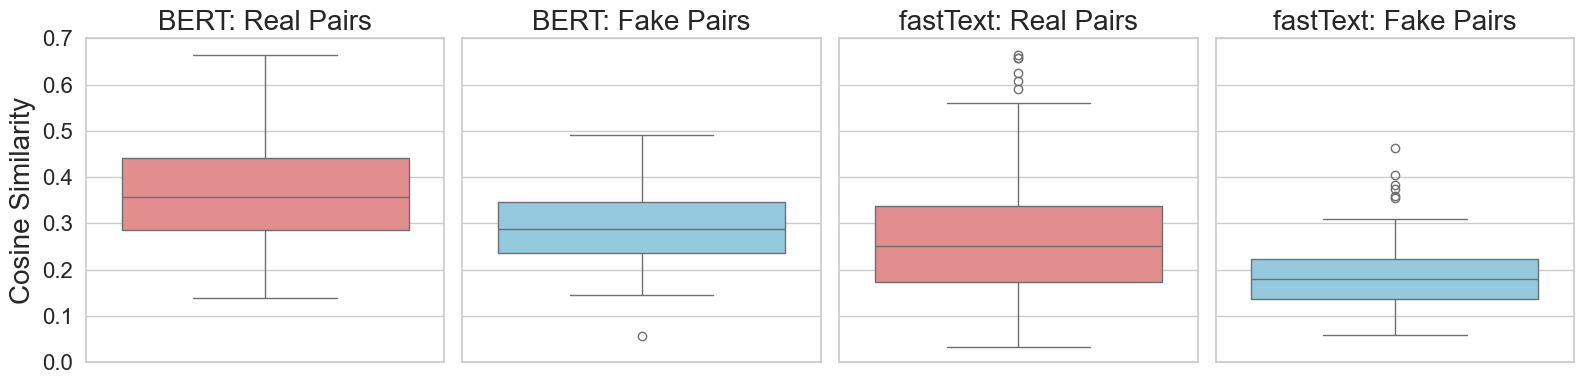

In [15]:
## 1.1 Exp 1: Plotting
# Set figure style
sns.set(style="whitegrid")

# Create a single-row, four-column figure
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Define font size
title_fontsize = 20  # 2x bigger
label_fontsize = 20  # 2x bigger
tick_fontsize = 16   # 2x bigger

# BERT Real neighbors
sns.boxplot(y=selected_words_df_real["cos_sim_neighbor_BERT"], color="lightcoral", ax=axes[0])
axes[0].set_title("BERT: Real Pairs", fontsize=title_fontsize)
axes[0].set_ylabel("Cosine Similarity", fontsize=label_fontsize)
axes[0].set_ylim(0, 0.7)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

# BERT Fake Pairs
sns.boxplot(y=selected_words_df_fake["cos_sim_neighbor_BERT"], color="skyblue", ax=axes[1])
axes[1].set_title("BERT: Fake Pairs", fontsize=title_fontsize)
axes[1].set_ylabel("", fontsize=label_fontsize)
axes[1].set_ylim(0, 0.7)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

# fastText Real Pairs
sns.boxplot(y=selected_words_df_real["cos_sim_neighbor_ft"], color="lightcoral", ax=axes[2])
axes[2].set_title("fastText: Real Pairs", fontsize=title_fontsize)
axes[2].set_ylabel("", fontsize=label_fontsize)
axes[2].set_ylim(0, 0.7)
axes[2].tick_params(axis='both', labelsize=tick_fontsize)

# fastText Fake Pairs
sns.boxplot(y=selected_words_df_fake["cos_sim_neighbor_ft"], color="skyblue", ax=axes[3])
axes[3].set_title("fastText: Fake Pairs", fontsize=title_fontsize)
axes[3].set_ylabel("", fontsize=label_fontsize)
axes[3].set_ylim(0, 0.7)
axes[3].tick_params(axis='both', labelsize=tick_fontsize)

# Adjust layout
plt.tight_layout()

# Save and show the figure
plt.savefig("result/cosine_similarity_boxplots_horizontal.png", dpi=300)
plt.show()

In [6]:
## 1-2. Exp 1: T-test
### Normality test
print("# Normality test")
    # BERT
print(fun.do_kstest(data=df, var_name="cos_sim_neighbor_BERT")) # likely non-normal
    # fastText
print(fun.do_kstest(data=df, var_name="cos_sim_neighbor_ft"), "\n")  # likely non-normal

### Wilcoxon signed-rank test (paired samples)
print("# Wilcoxon signed-rank test")
print("1) Real vs. Fake")
    # Real vs. Fake: BERT
print("BERT:", fun.do_wilcoxon_test(selected_words_df_real["cos_sim_neighbor_BERT"], selected_words_df_fake["cos_sim_neighbor_BERT"]))
    # Real vs. Fake: fastText
print("fastText:", fun.do_wilcoxon_test(selected_words_df_real["cos_sim_neighbor_ft"], selected_words_df_fake["cos_sim_neighbor_ft"]))

print("2) BERT vs. fastText")
print("Real:", fun.do_wilcoxon_test(selected_words_df_real["cos_sim_neighbor_BERT"], selected_words_df_real["cos_sim_neighbor_ft"]))
print("Fake:", fun.do_wilcoxon_test(selected_words_df_fake["cos_sim_neighbor_BERT"], selected_words_df_fake["cos_sim_neighbor_ft"]))

# Normality test
KS test statistic: 0.5466, p-value: 0.0000
(0.54657265923193, 1.4261511816487457e-56)
KS test statistic: 0.5178, p-value: 0.0000
(0.5178218130093507, 2.2433379594288205e-50) 

# Wilcoxon signed-rank test
1) Real vs. Fake
BERT: (907.0, 2.6485745381729024e-08)
fastText: (1100.0, 9.602565780219178e-07)
2) BERT vs. fastText
Real: (631.0, 7.406430736393852e-11)
Fake: (399.0, 2.673838131172043e-13)


In [7]:
# 2. Exp 2: Similar Words Retrieval
## 2.1 Data preparation
df = copy.deepcopy(selected_words_df_orig)

# ✅ Define analysis columns
k = 600
column_info = f"{k}_hanja"

    # Similar words: Similar words which only share Hangul syllables
num_sim_words_cols_BERT = [f"num_sim_words_neighbor_BERT_n{k}"]
num_sim_words_cols_ft = [f"num_sim_words_neighbor_ft_n{k}"]

     # True similar words: Similar words which share both Hangul and Hanja syllables
num_true_sim_words_cols_BERT = [f"num_true_sim_words_neighbor_BERT_n{column_info}"]
num_true_sim_words_cols_ft = [f"num_true_sim_words_neighbor_ft_n{column_info}"]

    # Ratio of true similar words
ratio_true_sim_words_cols_BERT = [f"ratio_true_sim_words_neighbor_BERT_n{column_info}"]
ratio_true_sim_words_cols_ft = [f"ratio_true_sim_words_neighbor_ft_n{column_info}"]

# ✅ Combine all analysis columns
all_analysis_cols_BERT = num_sim_words_cols_BERT + num_true_sim_words_cols_BERT + ratio_true_sim_words_cols_BERT
all_analysis_cols_ft = num_sim_words_cols_ft + num_true_sim_words_cols_ft + ratio_true_sim_words_cols_ft
all_analysis_cols = all_analysis_cols_BERT + all_analysis_cols_ft

# ✅ Convert to numeric
df[all_analysis_cols] = df[all_analysis_cols].apply(pd.to_numeric, errors='coerce')

# ratio to percent
df[f"ratio_true_sim_words_neighbor_BERT_n{column_info}"] = df[f"ratio_true_sim_words_neighbor_BERT_n{column_info}"]*100
df[f"ratio_true_sim_words_neighbor_ft_n{column_info}"] = df[f"ratio_true_sim_words_neighbor_ft_n{column_info}"]*100


## 2) Thresholds (25th percentile) for excluding low-frequency cases
df_real = df[df["real_fake"]==1]
df_fake = df[df["real_fake"]==0]

# Descriptive statistics (examples shown for BERT/fastText, real vs. fake)
df_real[f"num_sim_words_neighbor_BERT_n{k}"].describe()
    # count    100.00000
    # mean      94.88000
    # std       81.54286
    # min        1.00000
    # 25%       31.00000
    # 50%       73.00000
    # 75%      140.50000
    # max      344.00000
df_fake[f"num_sim_words_neighbor_BERT_n{k}"].describe()
    # count    100.000000
    # mean      36.490000
    # std       41.348603
    # min        0.000000
    # 25%        9.750000
    # 50%       22.500000
    # 75%       44.250000
    # max      220.000000
df_real[f"num_sim_words_neighbor_ft_n{k}"].describe()
    # count    100.000000
    # mean      74.850000
    # std       90.409436
    # min        2.000000
    # 25%       12.000000
    # 50%       37.000000
    # 75%       96.250000
    # max      397.000000
df_fake[f"num_sim_words_neighbor_ft_n{k}"].describe()
    # count    100.000000
    # mean      25.040000
    # std       31.988293
    # min        0.000000
    # 25%        6.000000
    # 50%       14.000000
    # 75%       26.250000
    # max      165.000000

# Thresholds based on 25th percentiles
threshold_BERT_real = 31
threshold_BERT_fake = 9
threshold_ft_real = 12
threshold_ft_fake = 6

In [8]:
## 2.3 Data cleaning
print("# Num. of datapoints")

    # ✅ Pair-wise filtering (within each real–fake pair)
idx_BERT = []
    
for i in range(0, len(df)//2, 2):
    val_real = df.loc[i, f"num_sim_words_neighbor_BERT_n{k}"]
    val_fake = df.loc[i+1, f"num_sim_words_neighbor_BERT_n{k}"]

    if (val_real >= threshold_BERT_real) and (val_fake >= threshold_BERT_fake):
        idx_BERT.append(i)
        idx_BERT.append(i+1)

df_pair_wise_BERT = df.loc[idx_BERT,:]; print("Pair-wise_BERT:", len(df_pair_wise_BERT))    # 60


idx_ft = []

for i in range(0, len(df)//2, 2):
    val_real = df.loc[i, f"num_sim_words_neighbor_ft_n{k}"]
    val_fake = df.loc[i+1, f"num_sim_words_neighbor_ft_n{k}"]

    if (val_real >= threshold_ft_real) and (val_fake >= threshold_ft_fake):
        idx_ft.append(i)
        idx_ft.append(i + 1)

df_pair_wise_ft = df.loc[idx_ft,:]; print("Pair-wise_fastText:", len(df_pair_wise_ft))    # 68


    # ✅ Model-wise filtering (within each model across real or fake items)
idx_real = []

for i in range(0, len(df_real)):
    val_BERT = df.loc[i, f"num_sim_words_neighbor_BERT_n{k}"]
    val_ft = df.loc[i, f"num_sim_words_neighbor_ft_n{k}"]

    if (val_BERT >= threshold_BERT_real) and (val_ft >= threshold_ft_real):
        idx_real.append(i)

df_model_wise_real = df.loc[idx_real,:]; print("Model-wise_Real:", len(df_model_wise_real))    # 46


idx_fake = []

for i in range(0, len(df_fake)):
    val_BERT = df.loc[i, f"num_sim_words_neighbor_BERT_n{k}"]
    val_ft = df.loc[i, f"num_sim_words_neighbor_ft_n{k}"]

    if (val_BERT >= threshold_BERT_fake) and (val_ft >= threshold_ft_fake):
        idx_fake.append(i)

df_model_wise_fake = df.loc[idx_fake,:]; print("Model-wise_Fake:", len(df_model_wise_fake))    # 71


# Num. of datapoints
Pair-wise_BERT: 60
Pair-wise_fastText: 68
Model-wise_Real: 46
Model-wise_Fake: 71


In [9]:
## 2.4 Functions
# ✅ **PAIR-WISE COMPARISON (Real vs. Fake)**
def analyze_pairwise_real_vs_fake(df, analysis_cols):
    """
    Compare BERT-real vs. BERT-fake & ft-real vs. ft-fake using Wilcoxon signed-rank test.
    Reports sample size (N), mean, SD, median, IQR, and p-values.
    """
    pairwise_results = {}

    for col in analysis_cols:
        real_values = df[df["real_fake"] == 1][col].dropna()
        fake_values = df[df["real_fake"] == 0][col].dropna()

        # Sample size
        n_real = len(real_values)
        n_fake = len(fake_values)

        # Compute statistics
        real_mean, real_sd = real_values.mean(), real_values.std()
        fake_mean, fake_sd = fake_values.mean(), fake_values.std()
        real_median, fake_median = real_values.median(), fake_values.median()
        real_iqr = real_values.quantile(0.75) - real_values.quantile(0.25)
        fake_iqr = fake_values.quantile(0.75) - fake_values.quantile(0.25)

        # Wilcoxon Signed-Rank Test
        diff_values = real_values - fake_values
        nonzero_diffs = diff_values[diff_values != 0]

        if len(nonzero_diffs) > 0:
            w_stat, w_p = wilcoxon(real_values, fake_values, alternative='two-sided', mode="approx")
        else:
            w_stat, w_p = np.nan, np.nan

        # Effect Sizes
        pooled_std = np.sqrt((real_sd ** 2 + fake_sd ** 2) / 2)
        cohen_d = (real_mean - fake_mean) / pooled_std if pooled_std > 0 else np.nan
        # delta = cliffs_delta(real_values.values, fake_values.values)

        pairwise_results[col] = {
            "N (Real)": n_real, "N (Fake)": n_fake,
            "Real Mean (SD)": f"{real_mean:.2f} ({real_sd:.2f})",
            "Fake Mean (SD)": f"{fake_mean:.2f} ({fake_sd:.2f})",
            "Real Median (IQR)": f"{real_median:.2f} ({real_iqr:.2f})",
            "Fake Median (IQR)": f"{fake_median:.2f} ({fake_iqr:.2f})",
            "Wilcoxon p-value": w_p
        }

    return pd.DataFrame(pairwise_results).T


# ✅ **MODEL-WISE COMPARISON (BERT vs. fastText)**
def analyze_modelwise_BERT_vs_fastText(df, analysis_cols):
    """
    Compare BERT-real vs. ft-real & BERT-fake vs. ft-fake using Wilcoxon signed-rank test.
    Reports sample size (N), mean, SD, median, IQR, and p-values.
    """
    modelwise_results = {}

    for bert_col, ft_col in zip(
        [col for col in analysis_cols if "BERT" in col],
        [col for col in analysis_cols if "ft" in col]
    ):
        df_paired = df[[bert_col, ft_col]].dropna()

        bert_values = df_paired[bert_col]
        ft_values = df_paired[ft_col]

        # Sample size
        n_bert, n_ft = len(bert_values), len(ft_values)

        # Compute statistics
        bert_mean, bert_sd = bert_values.mean(), bert_values.std()
        ft_mean, ft_sd = ft_values.mean(), ft_values.std()
        bert_median, ft_median = bert_values.median(), ft_values.median()
        bert_iqr = bert_values.quantile(0.75) - bert_values.quantile(0.25)
        ft_iqr = ft_values.quantile(0.75) - ft_values.quantile(0.25)

        # Wilcoxon Signed-Rank Test
        diff_values = bert_values - ft_values
        nonzero_diffs = diff_values[diff_values != 0]

        if len(nonzero_diffs) > 0:
            w_stat, w_p = wilcoxon(bert_values, ft_values, alternative='two-sided', mode="approx")
        else:
            w_stat, w_p = np.nan, np.nan

        modelwise_results[f"{bert_col} vs {ft_col}"] = {
            "N (BERT)": n_bert, "N (fastText)": n_ft,
            "BERT Mean (SD)": f"{bert_mean:.2f} ({bert_sd:.2f})",
            "fastText Mean (SD)": f"{ft_mean:.2f} ({ft_sd:.2f})",
            "BERT Median (IQR)": f"{bert_median:.2f} ({bert_iqr:.2f})",
            "fastText Median (IQR)": f"{ft_median:.2f} ({ft_iqr:.2f})",
            "Wilcoxon p-value": w_p
        }

    return pd.DataFrame(modelwise_results).T


In [10]:
## 2.5 Statistical comparisons

# Pairwise (within real–fake pairs) for each model
real_fake_results_df_BERT = analyze_pairwise_real_vs_fake(df=df_pair_wise_BERT, analysis_cols=all_analysis_cols_BERT)
real_fake_results_df_ft = analyze_pairwise_real_vs_fake(df=df_pair_wise_ft, analysis_cols=all_analysis_cols_ft)

# Model-wise (BERT vs. fastText) within each condition
modelwise_results_df_real = analyze_modelwise_BERT_vs_fastText(df=df_model_wise_real, analysis_cols=all_analysis_cols)
modelwise_results_df_fake = analyze_modelwise_BERT_vs_fastText(df=df_model_wise_fake, analysis_cols=all_analysis_cols)

# Show all columns when printing DataFrames
pd.options.display.max_columns = None

# Values used in the paper:
#   • Table 1: row 0 → num_sim_words_neighbor_...
#   • Table 2: row 3 → ratio_true_sim_words_neighbor_...
print("\n===== Pairwise Comparison: BERT (Real vs. Fake) =====")
print(real_fake_results_df_BERT)

print("\n===== Pairwise Comparison: fastText (Real vs. Fake) =====")
print(real_fake_results_df_ft)

print("\n===== Model-wise Comparison: Real (BERT vs. fastText) =====")
print(modelwise_results_df_real)

print("\n===== Model-wise Comparison: fake (BERT vs. fastText) =====")
print(modelwise_results_df_fake)




===== Pairwise Comparison: BERT (Real vs. Fake) =====
                                              N (Real) N (Fake)  \
num_sim_words_neighbor_BERT_n600                    30       30   
num_true_sim_words_neighbor_BERT_n600_hanja         30       30   
ratio_true_sim_words_neighbor_BERT_n600_hanja       30       30   

                                               Real Mean (SD) Fake Mean (SD)  \
num_sim_words_neighbor_BERT_n600               113.50 (70.40)  40.57 (43.28)   
num_true_sim_words_neighbor_BERT_n600_hanja       3.53 (3.59)    0.43 (1.07)   
ratio_true_sim_words_neighbor_BERT_n600_hanja     2.74 (2.54)    1.53 (4.06)   

                                              Real Median (IQR)  \
num_sim_words_neighbor_BERT_n600                  98.50 (92.75)   
num_true_sim_words_neighbor_BERT_n600_hanja         3.00 (4.75)   
ratio_true_sim_words_neighbor_BERT_n600_hanja       2.55 (3.75)   

                                              Fake Median (IQR)  \
num_sim_words_neigh

In [11]:
# 3. Exp. 3: Regression Analysis
## 3.1 Preprocessing
    ## 1) Log-transform frequency-related variables
columns = ["freq_BERT_relative", "freq_ft_relative", "neighbor_relative_freq_BERT",
           "neighbor_relative_freq_ft", "freq_real_neighbor_token_BERT_relative", "freq_real_neighbor_token_ft_relative"]

selected_words_df["log_freq_BERT_relative"] = np.log1p(selected_words_df["freq_BERT_relative"])
selected_words_df["log_freq_ft_relative"] = np.log1p(selected_words_df["freq_ft_relative"])
selected_words_df["log_neighbor_relative_freq_BERT"] = np.log1p(selected_words_df["neighbor_relative_freq_BERT"])
selected_words_df["log_neighbor_relative_freq_ft"] = np.log1p(selected_words_df["neighbor_relative_freq_ft"])
selected_words_df["log_freq_real_neighbor_token_BERT_relative"] = np.log1p(selected_words_df["freq_real_neighbor_token_BERT_relative"])
selected_words_df["log_freq_real_neighbor_token_ft_relative"] = np.log1p(selected_words_df["freq_real_neighbor_token_ft_relative"])

    # 2) Define columns for outlier removal (IQR method)
columns_BERT = ["log_freq_BERT_relative", "log_neighbor_relative_freq_BERT", "log_freq_real_neighbor_token_BERT_relative",]
columns_ft = ["log_freq_ft_relative", "log_neighbor_relative_freq_ft", "log_freq_real_neighbor_token_ft_relative",]
columns = columns_BERT + columns_ft

    # 3) Compute Q1, Q3, IQR for each column
Q1 = selected_words_df[columns].quantile(0.25)
Q3 = selected_words_df[columns].quantile(0.75)
IQR = Q3 - Q1

    # 4) Define lower and upper bounds for each column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

    # 5) Build a mask that excludes outliers in any column
condition = True
for col in columns:
    condition &= (selected_words_df[col] >= lower_bound[col]) & (selected_words_df[col] <= upper_bound[col])

    # 6) Apply the mask to remove outliers
selected_words_df_cleaned = selected_words_df[condition]
print(len(selected_words_df_cleaned)) # BERT + ft 108

# Replace with cleaned dataset
selected_words_df = selected_words_df_cleaned[:]
print(len(selected_words_df))   # 108 

108
108


In [ ]:
## 3.2 Split the dataset into subsets
df = copy.deepcopy(selected_words_df); print(len(df)) # 108

# Define predictor variables
predictors_continuous = ["log_freq_BERT_relative", "log_neighbor_relative_freq_BERT", "log_freq_real_neighbor_token_BERT_relative"]
predictors_categorical = ["morpheme_structure"]

predictors = predictors_continuous + predictors_categorical

    # 1) Split into real vs. fake subsets
real_df = df[(df["real_fake"] == 1)]; print(len(real_df))  # 56
fake_df = df[(df["real_fake"] == 0)]; print(len(fake_df))  # 52

    # 2) Define a helper function to fit and summarize OLS models
def fit_model(data, dependent_var, predictors):
    """
    Fits an OLS model, automatically handling categorical variables.

    Args:
        data (pd.DataFrame): The dataset.
        dependent_var (str): The dependent variable.
        predictors (list): List of predictor variable names.

    Returns:
        str: Summary of the fitted model.
    """
    formula_parts = []
    for predictor in predictors:
        if data[predictor].dtype == 'object' or data[predictor].dtype.name == 'category':
            formula_parts.append(f"C({predictor})")  # Convert categorical variables
        else:
            formula_parts.append(predictor)

    formula = f"{dependent_var} ~ {' + '.join(formula_parts)}"
    model = ols(formula=formula, data=data).fit()

    return model.summary()


108
56
52


In [14]:
## 3.3 Fit models for each subset
    # BERT
dependent_var = "cos_sim_neighbor_BERT"

print("\n### BERT: Real Pairs ###")
print(fit_model(data=real_df, dependent_var=dependent_var, predictors=predictors))

print("\n### BERT: Fake Pairs ###")
print(fit_model(data=fake_df, dependent_var=dependent_var, predictors=predictors))


    # fastText
print("\n### fastText: Real Pairs ###")
dependent_var_ft = "cos_sim_neighbor_ft"
print(fit_model(data=real_df, dependent_var=dependent_var_ft, predictors=predictors))

print("\n### fastText: Fake Pairs ###")
print(fit_model(data=fake_df, dependent_var=dependent_var_ft, predictors=predictors))


### BERT: Real Pairs ###
                              OLS Regression Results                             
Dep. Variable:     cos_sim_neighbor_BERT   R-squared:                       0.203
Model:                               OLS   Adj. R-squared:                  0.140
Method:                    Least Squares   F-statistic:                     3.244
Date:                   Sat, 20 Sep 2025   Prob (F-statistic):             0.0191
Time:                           14:39:05   Log-Likelihood:                 52.993
No. Observations:                     56   AIC:                            -95.99
Df Residuals:                         51   BIC:                            -85.86
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------